### Projet de Compressed Sensing


# Analyse d'images en astronomie: ondelettes et inpainting

*Léa Bresson, Arnaud Valladier*

### Sommaire

[1. Introduction](#intro)<br>
[2. Préparation des données](#prep)<br>
[3. Isotropic Undecimated Wavelet Transform](#inp1)<br>
[4. Nuclear Norm Minimisation](#inp2)<br>
[5. Proximal Gradient Descent](#inp3)<br>
[6. Benchmark des différentes méthodes](#benchmark)<br>
[7. Choix des hyperparamètres](#hyp)<br>
[8. Conclusion](#conclu)<br>


<a id='intro'></a>
## 1. Introduction


Le problème des données manquantes est récurrent dans le domaine de l'astronomie. En effet, les images issues des microscopes souffrent souvent de "zones d'ombres" (mauvaise qualité de l'image, mauvaise calibration, etc.). Les techniques d'*inpainting* consistent à "remplir" ces zones masquées.


**Formalisation du problème:**

Soient X l'image complète (non observée), Y l'image observée souffrant de zone "masquées", et L un masque binaire. On a $Y=LX$. L'objectif est alors de retrouver X sachant que l'on connait Y et L. Pour résoudre ce problème, nous comparons deux techniques: 

- la première méthode se place dans une base d'ondelettes et effectue une approximation par seuillage itératif. L'approche mathématique d'un tel algorithme est développée dans notre rapport.

- la seconde technique repose sur la complétion de matrices (ici matrices de pixels) par minimisation de la norme nucléaire. L'approche mathématique a été étudiée en cours (http://lecueguillaume.github.io/assets/10_matrice_completion.pdf).


L'objet de ce notebook est donc de vérifier si l'algorithme basé sur les ondelettes est, comme le suggérerait la théorie, plus efficace pour estimer des images représentant des structures fractales.



**Implémentation:**

Nous allons implémenter la technique de l'inpainting à une photo prise par le télescope Herschel (https://www.herschel.caltech.edu/images). Pour ce faire, nous appliquons un masque binaire à l'image considérée.


Nous nous sommes inspirés des codes de Jerome Bobin pour la première méthode (le code du fichier pyPW2 a été crée par J.Bobin - http://jbobin.cosmostat.org/master-2-mva).

<a id='prep'></a>
## 2. Préparation des données

In [2]:
import numpy as np
import pandas as pd
import astropy.io.fits as pyf #nécessite "pip install astropy"
%matplotlib inline
import matplotlib.pyplot as plt
from time import time
import scipy.ndimage as sim
from cvxpy import *
print(installed_solvers())

# L'implémention de l'algorithme à trous et de la déconvolution sont présents dans le fichier pyPW2.py
import pyPW2 as pw2

from jupyterthemes import jtplot
# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='oceans16', grid=False)

['CVXOPT', 'GLPK_MI', 'LS', 'ECOS_BB', 'SCS', 'ECOS', 'GLPK']


Prenons par l'exemple l'image `'black_hole_wind_new'` dans le jeu de données proposée. Pour ne pas avoir des calculs trop longs, nous en prendrons seulement une partie.

Text(0.5,1,'Input image')

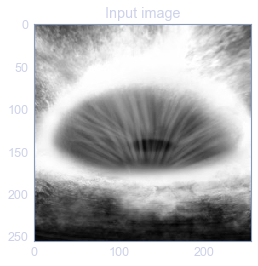

In [3]:
# Conversion de l'image en image numérique/tableau de pixels
cmap = 'gray' # or coolwarm or Greys or gray
f = plt.imread('Data/black_hole_wind_new.jpg').astype('double') #(longueur, largeur, couleur chanel)
f = f[120:(120 + 256), 200:(200 + 256):]
x = np.sum(f,axis=2) #(longueur, largeur)
plt.imshow(x, cmap=cmap)
plt.title('Input image')

Création d'un masque binaire, la proportion de pixels non-masqués est fixée par défaut à $0.2$.

In [4]:
def mask_generator(u, v, proportion = 0.2):
    """
    Generate a mask given the shape of the matrix (u, v) and the proportion of known entries of the matrix
    """
    mat_mask = np.random.binomial(1, proportion, size =  (u, v))
    print("We observe %.2f" % (100 * mat_mask.mean()) + " per cent of the entries of a {}*{} matrix".format(u, v))
    return mat_mask

Prenons un exemple en gardant $20\%$ des données:

We observe 19.95 per cent of the entries of a 256*256 matrix


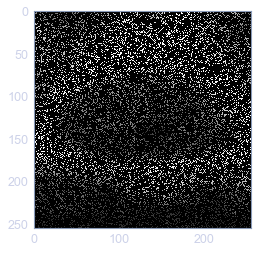

In [5]:
plt.imshow(x * mask_generator(x.shape[0], x.shape[1], 0.2), cmap=cmap)

Création d'une fonction plot qui sera utilisée pour illustrer nos algorithmes:

In [6]:
def plot_inpainting(input_image, inpainted, masked, mask, error=None):
    """
    Plot the input image, the inpainted image, the masked image, the mask and the residuals
    """
    plt.figure(figsize=(25.0, 12.0))
    #If the error is not given, we compute it
    if error is None:
        error = np.linalg.norm(inpainted - input_image, 2) / np.linalg.norm(input_image, 2)
    plt.suptitle('Inpainting: erreur relative = %.2e' % error, fontsize=20.0)
    plt.subplot(2, 3, 1)
    plt.imshow(input_image,cmap=cmap)
    plt.title('Input image')
    plt.subplot(2, 3, 2)
    plt.imshow(inpainted, cmap=cmap)
    plt.title('Inpainted image')
    plt.subplot(2, 3, 3)
    plt.imshow(masked,cmap=cmap)
    plt.title('Masked')
    plt.subplot(2, 3, 4)
    plt.imshow(mask,cmap=cmap)
    plt.title('Mask')
    plt.subplot(2, 3, 5)
    plt.imshow(input_image - inpainted, cmap=cmap)
    plt.title('Residuals')
    plt.show()

<a id='inp1'></a>
## 3. Isotropic Undecimated Wavelet Transform


Nous utilisons l'algorithme 'Isotropic Undecimated Wavelet Transform' décrit par l'article au sein d'une fonction destinée à apprécier ses performances:

In [7]:
def inpainting_astro(input_image, nmax=500, J=3, k_mad=3, tol=1e-4, mask=None, proportion=0.2, error=True, timer=True, plot=True):
    """
    Inpainting using Isotropic Undecimated Wavelet Transform (IUWT)
    Input : input_image - N x M array 
            nmax - scalar - maximum number of iterations
            J - scalar - number of starlet scales
            k_mad - scalar - value of the k-mad threshold
            tol - scalar - stopping criterion 
            mask - N x M array (binary mask) - if 'None', a binomial mask is calculated
            proportion - if mask=None, represented the proportion of unmodified pixel of the masked image.
                         If 'mask' is not 'None', 'proportion' is ignored.
            error - True => the relative error in 2-norm is returned
            timer - True => print the time consummed by the algorithm
            plot - True => plot several image: the input, the inpainted, the masked, the mask and the residuals
    Output : inpainted - N x M array
             err - scalar - relative error in 2-norm (if error=True)
    """
    #Timer initialization
    start = time()
    #Create a mask if corresponding argument is 'None'
    if mask is None:
        n, p = x.shape
        mask = mask_generator(n, p, proportion)
    #Creation of the masked image
    masked = np.multiply(mask, x)
    #Run of the procedure
    start_inpainting = time()
    inpainted = pw2.Prox_Inp(masked, mask, nmax, J, k_mad, tol)
    #Print timer
    if timer:
        print("Inpainting time: %.2f" % (time() - start_inpainting) + "s")
    #Plot the input image, the masked image, the inpainted image on the first line
    #Plot the mask and the residuals on the second line
    if plot:       
        plot_inpainting(input_image, inpainted, masked, mask)
    #Return total timer
    if timer:
        print("Total time of the procedure: %.2f" % (time() - start) + "s") 
    #Return the inpainted matrix (and the error)       
    if error:
        err = np.linalg.norm(inpainted - input_image, 2) / np.linalg.norm(input_image, 2)
        print("Erreur relative: %.4f" % err)
        return inpainted, err
    else:
        return inpainted

La ligne ```python inpainted = pw2.Prox_Inp(masked, mat_mask , nmax, J, k_mad, tol)```  implémente un algorithme forward backward qui minimise le problème suivant:
$$ min_x \text{  } \lambda ||x \phi ^T ||_{\ell_1} + \frac{1}{2}||b-M \otimes x ||_2^2 $$ 

Avec $b$ l'image observée, $\phi^T$ la transformée en ondelettes isotropes (appelée aussi *"Starlet transform"*) , $M$ le masque binaire et $x$ l'image que l'on souhaite retrouver.

We observe 20.18 per cent of the entries of a 256*256 matrix
Inpainting time: 119.79s


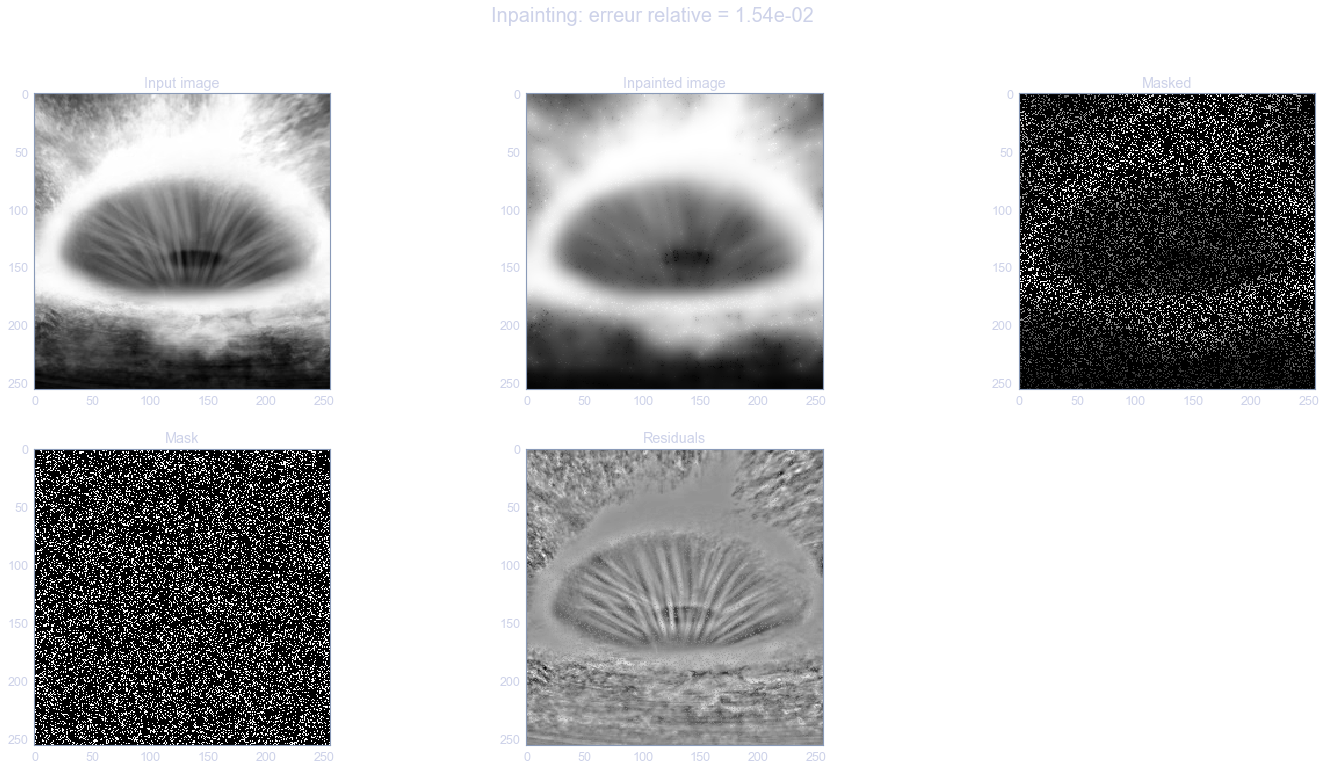

Total time of the procedure: 120.49s
Erreur relative: 0.0154


In [8]:
x_inpainted_astro, error_astro = inpainting_astro(x)

Visuellement, on observe une bonne reconstruction de l'image. A l'oeil, la seul différence constatable est une baisse du contraste. L'erreur relative calculée est faible.

<a id='inp2'></a>
## 4. Nuclear Norm Minimization


In [9]:
def nuclear_norm_mini(mat_mask, image):
    """
    Solver of Nuclear Norm Minimization using cvxpy
    """
    #Problem setting
    u, v = image.shape
    A = Variable(u, v)
    obj = Minimize(norm(A, 'nuc'))
    constraints = [mul_elemwise(mat_mask, A) == mul_elemwise(mat_mask, np.array(image))]
    prob = Problem(obj, constraints)
    #Process
    prob.solve(solver=SCS)
    if prob.status != 'optimal':
        print('CVXPY failed to reach optimal value')
    return A.value

In [10]:
def inpainting_NNM(input_image, mask=None, proportion=0.2, error=True, timer=True, plot=True):
    """
    Inpainting using Nuclear Norm Minimization (NNM)
    Input : input_image - N x M array 
            mask - N x M array (binary mask) - if 'None', a binomial mask is calculated
            proportion - if mask=None, represented the proportion of unmodified pixel of the masked image
                         If 'mask' is not 'None', 'proportion' is ignored.
            error - True => the relative error in 2-norm is returned
            timer - True => print the time consummed by the algorithm
            plot - True => plot several image: the input, the inpainted, the masked, the mask and the residuals
    Output : inpainted - N x M array
             err - scalar - relative error in 2-norm (if error=True)
    """
    start = time()
    #Create a mask if corresponding argument is 'None'
    if mask is None:
        n, p = x.shape
        mask = mask_generator(n, p, proportion)
    #Creation of the masked image
    masked = np.multiply(mask, x)
    #Run of the procedure
    start_inpainting = time()
    inpainted = nuclear_norm_mini(mask, input_image)
    #Print timer
    if timer:
        print("Inpainting time: %.2f" % (time() - start_inpainting) + "s")
    #Plot the input image, the masked image, the inpainted image on the first line
    #Plot the mask and the residuals on the second line
    if plot:
        plot_inpainting(input_image, inpainted, masked, mask)
    #Return total timer
    if timer:
        print("Total time of the procedure: %.2f" % (time() - start) + "s") 
    #Return the inpainted matrix (and the error)       
    if error:
        err = np.linalg.norm(inpainted - input_image, 2) / np.linalg.norm(input_image, 2)
        print("Erreur relative: %.4f" % err)
        return inpainted, err
    else:
        return inpainted

We observe 19.89 per cent of the entries of a 256*256 matrix
Inpainting time: 62.73s


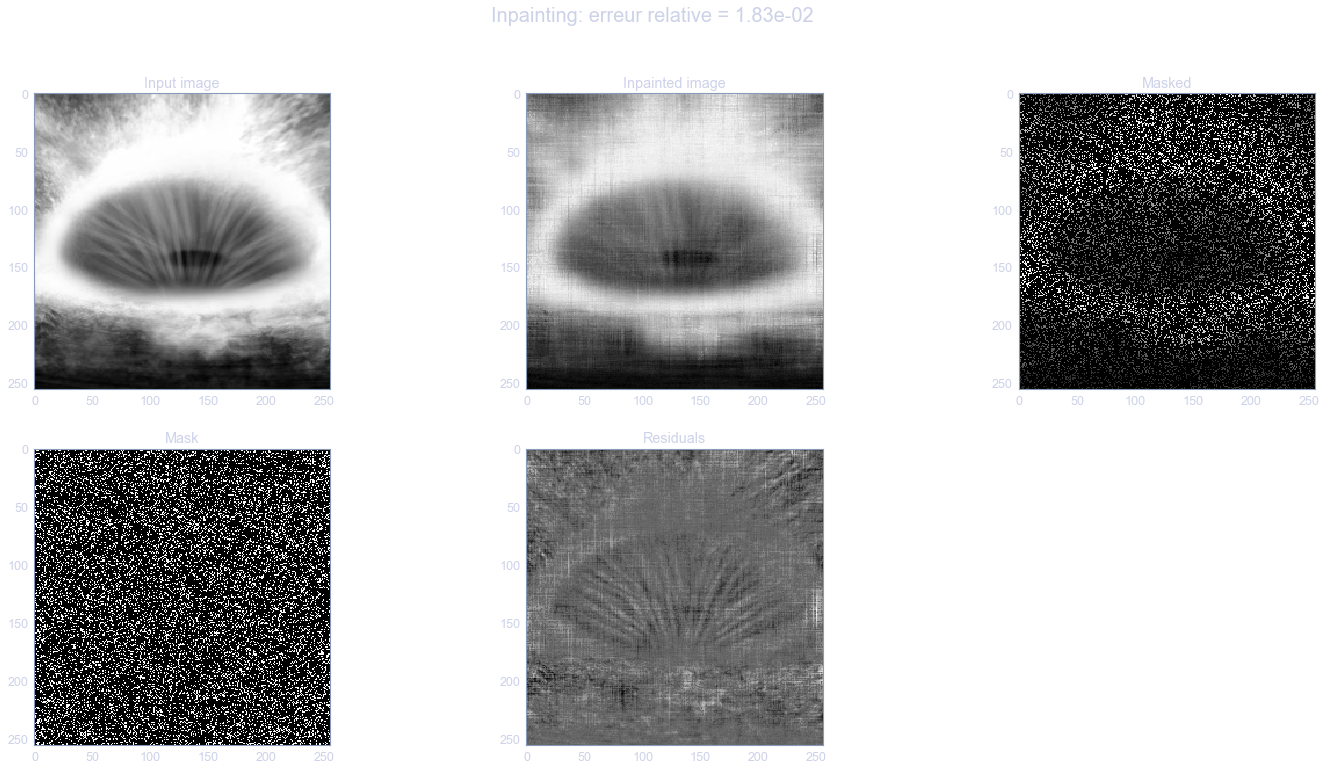

Total time of the procedure: 63.50s
Erreur relative: 0.0183


In [11]:
x_inpainted_NNM, error_astro = inpainting_NNM(x)

On obtient un meilleur résultat ici.

<a id='inp3'></a>
## 5. Proximal Gradient Descent

In [12]:
from numpy.linalg import svd

In [13]:
def spectral_soft_thresh(A, mu):
    """Compute the spectral soft thresholding"""
    U, s, V = svd(A)
    s_mu = (s - mu) * (s > mu)
    return np.dot(U, np.dot(np.diag(s_mu), V))

In [14]:
def prox_grad_descent(image, image_masked, mat_mask, mu, n_iter=400, tol=1e-4,  verbose = False):
    """
    Compute the proximal gradient descent using spectral soft thresholding
    """
    list_errors = []
    A = np.zeros(image_masked.shape)
    for i in range(n_iter + 1):
        A = spectral_soft_thresh(A * (1 - mat_mask) + image_masked, mu)
        err = np.linalg.norm(A - image, 2) / np.linalg.norm(image, 2)
        list_errors.append(err)
        #If verbose
        if i % 20 == 0 and verbose == True:
            print("iteration = {}; error = {}".format(i, err))
            plt.figure
            plt.imshow(A, cmap = plt.cm.gray)
            plt.show()
        #Stoppin criterium
        if err < tol: break
    return A, list_errors

In [15]:
def inpainting_PGD(input_image, mu=200, n_iter=400, tol=1e-4, mask=None, proportion=0.2, timer=True, plot=True):
    """
    Inpainting using Proximal Gradient Descent
    Input : input_image - N x M array 
            mu - scalar - soft thresholding
            n_iter - integer - number of iterations in proximal gradient descent
            tol - scalar - stoppin criterium on the relative error
            mask - N x M array (binary mask) - if 'None', a binomial mask is calculated
            proportion - if mask=None, represented the proportion of unmodified pixel of the masked image
                         If 'mask' is not 'None', 'proportion' is ignored
            timer - True => print the time consummed by the algorithm
            plot - True => plot several image: the input, the inpainted, the masked, the mask and the residuals
    Output : inpainted - N x M array
             err - scalar - relative error in 2-norm
    """
    start = time()
    #Create a mask if corresponding argument is 'None'
    if mask is None:
        n, p = x.shape
        mask = mask_generator(n, p, proportion)
    #Creation of the masked image
    masked = np.multiply(mask, x)
    #Run of the procedure
    start_inpainting = time()
    inpainted, err = prox_grad_descent(input_image, masked, mask, mu, n_iter, verbose = False)
    #Print timer
    if timer:
        print("Inpainting time: %.2f" % (time() - start_inpainting) + "s")
    #Plot the input image, the masked image, the inpainted image on the first line
    #Plot the mask and the residuals on the second line
    if plot:
        plot_inpainting(input_image, inpainted, masked, mask)
    #Return total timer
    if timer:
        print("Total time of the procedure: %.2f" % (time() - start) + "s") 
    #Return the inpainted matrix (and the error)  
    print("Erreur relative: %.4f" % err[-1])
    return inpainted, err[-1]

We observe 20.00 per cent of the entries of a 256*256 matrix
Inpainting time: 10.51s


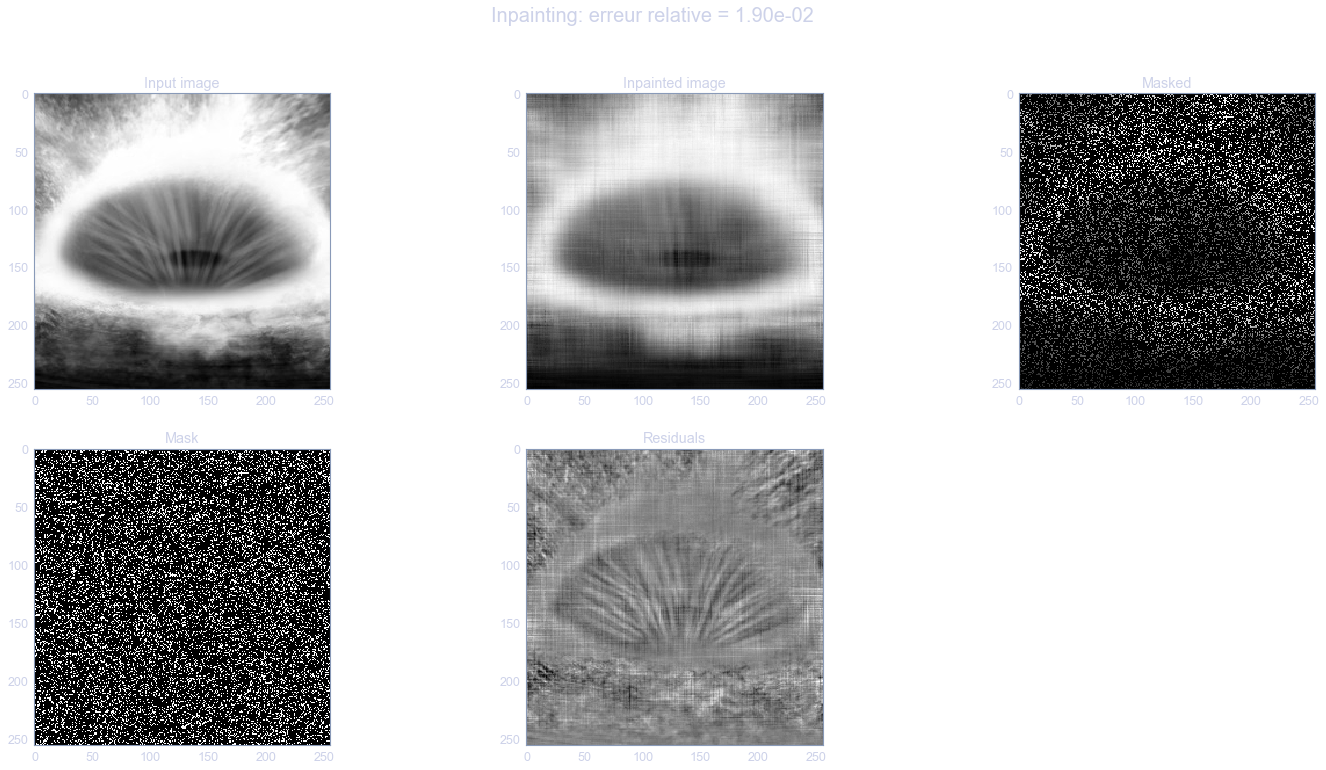

Total time of the procedure: 11.23s
Erreur relative: 0.0190


In [16]:
x_inpainted_PGD, error_PGD = inpainting_PGD(x)

<a id='benchmark'></a>
## 6. Benchmark des différentes méthodes

Nous calculons l'erreur commise et le temps nécessaire aux calculs pour chaque méthode dans le but de comparer leurs performances.

In [17]:
proportion = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

def benchmark(method, input_image, proportion=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
    """
    Compute the relative error the inpainted image given a method and a set of proportion of known entries of the input image
    Benchmark++ : compute each error several time and take the average => better benchmark but time consuming!!! =(
    """
    errors = []
    timer = []
    for prop in proportion:
        start = time()
        _, err = method(input_image, plot=False, proportion=prop)
        timer.append(time() - start)
        errors.append(err)
    return np.array(errors), np.array(timer)

#### ATTENTION: les calculs sont assez long!
Les résultats ont été enregistré dans des fichiers pour ne pas avoir à refaire les calculs.

In [18]:
benchmark_astro, timer_astro = benchmark(inpainting_astro, x)
save_astro = pd.DataFrame([benchmark_astro, timer_astro, proportion]).T
save_astro.to_csv('benchmark_astro.csv')

We observe 10.15 per cent of the entries of a 256*256 matrix
Inpainting time: 311.19s
Total time of the procedure: 311.19s
Erreur relative: 0.0496
We observe 19.98 per cent of the entries of a 256*256 matrix
Inpainting time: 115.05s
Total time of the procedure: 115.05s
Erreur relative: 0.0149
We observe 29.86 per cent of the entries of a 256*256 matrix
Inpainting time: 78.88s
Total time of the procedure: 78.88s
Erreur relative: 0.0119
We observe 40.22 per cent of the entries of a 256*256 matrix
Inpainting time: 57.69s
Total time of the procedure: 57.69s
Erreur relative: 0.0106
We observe 49.94 per cent of the entries of a 256*256 matrix
Inpainting time: 46.91s
Total time of the procedure: 46.91s
Erreur relative: 0.0093
We observe 60.06 per cent of the entries of a 256*256 matrix
Inpainting time: 34.44s
Total time of the procedure: 34.44s
Erreur relative: 0.0082
We observe 69.72 per cent of the entries of a 256*256 matrix
Inpainting time: 33.34s
Total time of the procedure: 33.35s
Erreu

In [19]:
benchmark_NNM, timer_NNM = benchmark(inpainting_NNM, x)
save_NNM = pd.DataFrame([benchmark_NNM, timer_NNM, proportion]).T
save_NNM.to_csv('benchmark_NNM.csv')

We observe 10.07 per cent of the entries of a 256*256 matrix
Inpainting time: 51.68s
Total time of the procedure: 51.68s
Erreur relative: 0.0418
We observe 20.01 per cent of the entries of a 256*256 matrix
Inpainting time: 68.35s
Total time of the procedure: 68.35s
Erreur relative: 0.0202
We observe 30.01 per cent of the entries of a 256*256 matrix
Inpainting time: 74.64s
Total time of the procedure: 74.64s
Erreur relative: 0.0097
We observe 39.99 per cent of the entries of a 256*256 matrix
Inpainting time: 87.60s
Total time of the procedure: 87.60s
Erreur relative: 0.0075
We observe 49.96 per cent of the entries of a 256*256 matrix
Inpainting time: 96.55s
Total time of the procedure: 96.55s
Erreur relative: 0.0047
We observe 59.99 per cent of the entries of a 256*256 matrix
Inpainting time: 105.24s
Total time of the procedure: 105.25s
Erreur relative: 0.0033
We observe 69.95 per cent of the entries of a 256*256 matrix
Inpainting time: 110.92s
Total time of the procedure: 110.92s
Erreu

In [20]:
benchmark_PGD, timer_PGD = benchmark(inpainting_PGD, x)
save_PGD = pd.DataFrame([benchmark_PGD, timer_PGD, proportion]).T
save_PGD.to_csv('benchmark_PGD.csv')

We observe 9.91 per cent of the entries of a 256*256 matrix
Inpainting time: 10.80s
Total time of the procedure: 10.80s
Erreur relative: 0.0907
We observe 19.62 per cent of the entries of a 256*256 matrix
Inpainting time: 10.74s
Total time of the procedure: 10.74s
Erreur relative: 0.0207
We observe 30.11 per cent of the entries of a 256*256 matrix
Inpainting time: 10.70s
Total time of the procedure: 10.71s
Erreur relative: 0.0112
We observe 39.63 per cent of the entries of a 256*256 matrix
Inpainting time: 10.72s
Total time of the procedure: 10.72s
Erreur relative: 0.0081
We observe 50.06 per cent of the entries of a 256*256 matrix
Inpainting time: 10.72s
Total time of the procedure: 10.72s
Erreur relative: 0.0060
We observe 59.65 per cent of the entries of a 256*256 matrix
Inpainting time: 10.76s
Total time of the procedure: 10.78s
Erreur relative: 0.0047
We observe 69.97 per cent of the entries of a 256*256 matrix
Inpainting time: 10.76s
Total time of the procedure: 10.76s
Erreur rel

In [21]:
benchmark_astro = pd.read_csv('benchmark_astro.csv', index_col=0, names=['Erreur', 'Timer', 'Proportion'], header=0)
benchmark_NNM = pd.read_csv('benchmark_NNM.csv', index_col=0, names=['Erreur', 'Timer', 'Proportion'], header=0)
benchmark_PGD = pd.read_csv('benchmark_PGD.csv', index_col=0, names=['Erreur', 'Timer', 'Proportion'], header=0)

In [22]:
benchmark_PGD

,Erreur,Timer,Proportion
0,0.090668,10.799613,0.1
1,0.020727,10.738853,0.2
2,0.011243,10.708023,0.3
3,0.008100,10.720848,0.4
4,0.006002,10.715457,0.5
5,0.004739,10.779059,0.6
6,0.003769,10.764399,0.7
7,0.002960,11.370167,0.8
8,0.002269,12.985542,0.9


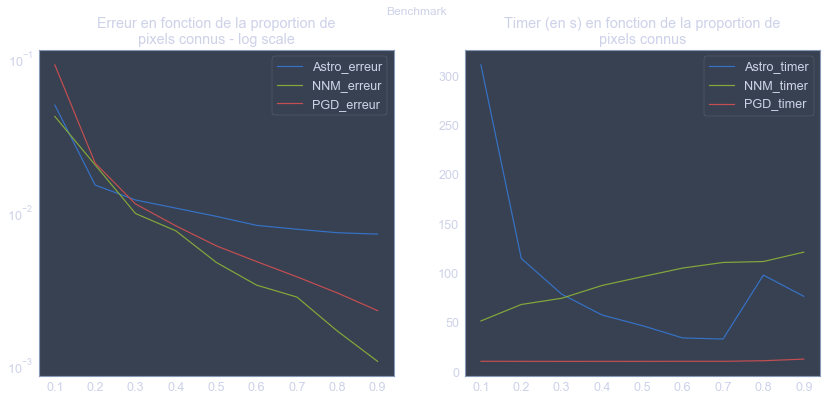

In [23]:
plt.figure(figsize=(14.0, 6.0))
plt.suptitle('Benchmark')
plt.subplot(1,2,1)
plt.title('Erreur en fonction de la proportion de\npixels connus - log scale')
plt.semilogy(benchmark_astro.Proportion, benchmark_astro.Erreur, label='Astro_erreur')
plt.semilogy(benchmark_astro.Proportion, benchmark_NNM.Erreur, label='NNM_erreur')
plt.semilogy(benchmark_astro.Proportion, benchmark_PGD.Erreur, label='PGD_erreur')
plt.legend()
plt.subplot(1,2,2)
plt.title('Timer (en s) en fonction de la proportion de\npixels connus')
plt.plot(benchmark_astro.Proportion, benchmark_astro.Timer, label='Astro_timer')
plt.plot(benchmark_astro.Proportion, benchmark_NNM.Timer, label='NNM_timer')
plt.plot(benchmark_astro.Proportion, benchmark_PGD.Timer, label='PGD_timer')
plt.legend()

Les performances de la méthode NNM sont uniformément meilleures que celle de l'IUWT (astro_erreur) concernant l'erreur de reconstruction. Cependant, IUWT est nettement plus rapide dès que la proportion de pixels connue est supérieure ou égale à $0.3$. La méthode PGD montre de meilleurs résultats que IUWT et se révèle être beaucoup plus rapide que les deux autres. PGD ne dépasse pas les 20 secondes, cet algorithme est donc entre 2 à 10 fois plus rapide que les deux autres méthodes.

On remarque un cap entre les proportions $0.1$ et $0.2$. En effet, entre ces deux valeurs, la précision des deux méthodes chute drastiquement. De plus, de manière assez contre-intuitive, la vitesse de convergence de la méthode NNM croit lorsque la proportion de pixels connus augmentent.

De la même façon, concernant l'algorithme IUWT, on constate que les timers pour des proportions de $0.8$ et $0.9$ sont plus élevé que le timer correspondant à la proportion $0.7$.

<a id='hyp'></a>
# 7. Choix des hyper-paramètres

Fixons une proportion de pixels connues à $0.4$. Déterminons les meilleurs paramètres possible pour chaque algorithme.

## 7.1 Proximal Gradient Descent: choix du seuil $\mu$

In [24]:
import pylab as pl
from IPython import display
from time import sleep

In [ ]:
%matplotlib inline
import time
import pylab as pl
from IPython import display

In [25]:
error = []
inpainted_list = []

mask = mask_generator(x.shape[0], x.shape[1], proportion=0.4)
masked = np.multiply(x, mask)

mu_list = np.arange(0,1000,50) + 50

for mu in mu_list:
    inpainted, err = inpainting_PGD(x, mu=mu, mask=mask, proportion=0.4, plot=False)
    error.append(err)
    inpainted_list.append(inpainted)

We observe 39.88 per cent of the entries of a 256*256 matrix
Inpainting time: 10.22s
Total time of the procedure: 10.22s
Erreur relative: 0.0284
Inpainting time: 10.12s
Total time of the procedure: 10.12s
Erreur relative: 0.0070
Inpainting time: 10.96s
Total time of the procedure: 10.96s
Erreur relative: 0.0074
Inpainting time: 13.20s
Total time of the procedure: 13.20s
Erreur relative: 0.0079
Inpainting time: 12.31s
Total time of the procedure: 12.31s
Erreur relative: 0.0085
Inpainting time: 11.74s
Total time of the procedure: 11.74s
Erreur relative: 0.0092
Inpainting time: 11.55s
Total time of the procedure: 11.55s
Erreur relative: 0.0100
Inpainting time: 12.34s
Total time of the procedure: 12.34s
Erreur relative: 0.0108
Inpainting time: 12.20s
Total time of the procedure: 12.20s
Erreur relative: 0.0117
Inpainting time: 12.40s
Total time of the procedure: 12.40s
Erreur relative: 0.0125
Inpainting time: 10.88s
Total time of the procedure: 10.88s
Erreur relative: 0.0134
Inpainting time

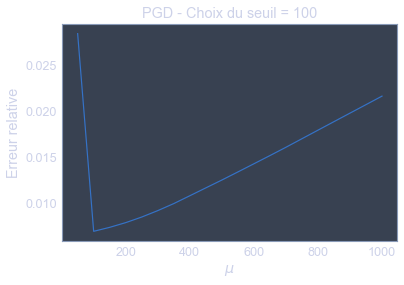

In [26]:
plt.plot(mu_list, error)
plt.title("PGD - Choix du seuil = %d" % mu_list[np.argmin(error)])
plt.xlabel('$\mu$')
plt.ylabel('Erreur relative')
plt.show()

On constate que le minimum trouvé est assez grossier. Pour l'approcher plus finement, considérons des valeurs régulières de $\mu$ entre 50 et 100:

In [27]:
error_bis = []
inpainted_list_bis = []

mask = mask_generator(x.shape[0], x.shape[1], proportion=0.4)
masked = np.multiply(x, mask)

mu_list_bis = np.arange(50,110, 10)

for mu in mu_list:
    inpainted, err = inpainting_PGD(x, mu=mu, mask=mask, proportion=0.4, plot=False)
    error_bis.append(err)
    inpainted_list_bis.append(inpainted)

We observe 40.23 per cent of the entries of a 256*256 matrix
Inpainting time: 10.39s
Total time of the procedure: 10.39s
Erreur relative: 0.0236
Inpainting time: 9.88s
Total time of the procedure: 9.88s
Erreur relative: 0.0069
Inpainting time: 9.92s
Total time of the procedure: 9.92s
Erreur relative: 0.0074
Inpainting time: 9.88s
Total time of the procedure: 9.88s
Erreur relative: 0.0080
Inpainting time: 10.26s
Total time of the procedure: 10.26s
Erreur relative: 0.0087
Inpainting time: 10.58s
Total time of the procedure: 10.58s
Erreur relative: 0.0095
Inpainting time: 10.63s
Total time of the procedure: 10.63s
Erreur relative: 0.0102
Inpainting time: 10.61s
Total time of the procedure: 10.61s
Erreur relative: 0.0110
Inpainting time: 10.60s
Total time of the procedure: 10.60s
Erreur relative: 0.0119
Inpainting time: 10.61s
Total time of the procedure: 10.61s
Erreur relative: 0.0127
Inpainting time: 10.68s
Total time of the procedure: 10.68s
Erreur relative: 0.0135
Inpainting time: 10.6

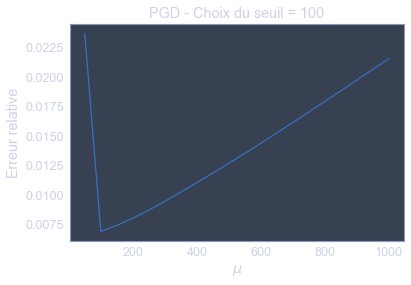

In [28]:
plt.plot(mu_list, error_bis)
plt.title("PGD - Choix du seuil = %d" % mu_list[np.argmin(error_bis)])
plt.xlabel('$\mu$')
plt.ylabel('Erreur relative')
plt.show()

La plus faible erreur relative est obtenue pour $\mu = 80$. La courbe est assez plate entre $70$ et $90$ pour se sentir satisfait de ce minimiseur.

Voyons l'évolution de la reconstitution en faisant varier $\mu$ de $1000$ jusqu'à $80$.

In [29]:
mu_list = np.arange(0,1000, 50) + 50

error_reverse = error[::-1]
mu_list_reverse = mu_list[::-1]
inpainted_list_reverse = inpainted_list[::-1]

error_reverse = error_reverse[0:22:2]
mu_list_reverse = mu_list_reverse[0:22:2]
inpainted_list_reverse = inpainted_list_reverse[0:22:2]

mu_list_reverse = np.append(mu_list_reverse, mu_list_bis[np.argmin(error_bis)])
error_reverse.append(np.min(error_bis))
inpainted_list_reverse.append(inpainted_list_bis[np.argmin(error_bis)])

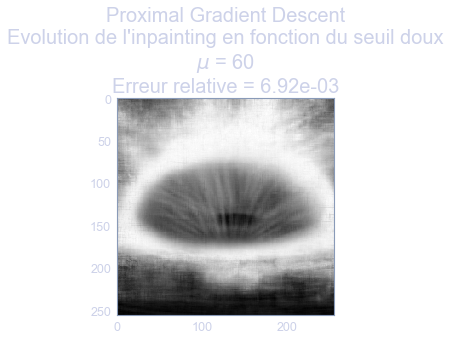

In [30]:
for i in range(len(error_reverse)):
    plt.title("Proximal Gradient Descent\nEvolution de l'inpainting en fonction du seuil doux\n$\mu$ = %d" % mu_list_reverse[i] + 
                 "\nErreur relative = %.2e" % error_reverse[i], fontsize=20.0)
    plt.imshow(inpainted_list_reverse[i], cmap=cmap)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    sleep(1)

Regardons l'évolution des résidus:

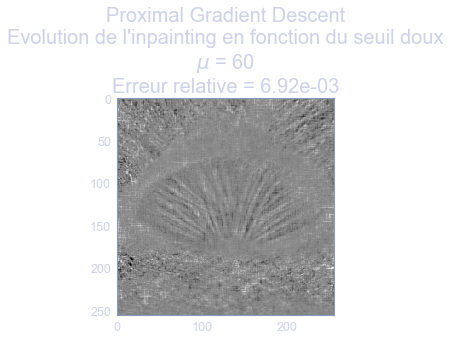

In [31]:
for i in range(len(error_reverse)):
    plt.title("Proximal Gradient Descent\nEvolution de l'inpainting en fonction du seuil doux\n$\mu$ = %d" % mu_list_reverse[i] + 
                 "\nErreur relative = %.2e" % error_reverse[i], fontsize=20.0)
    plt.imshow(x - inpainted_list_reverse[i], cmap=cmap)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    sleep(1)

On constate une différence visible de la reconstitution en fonction de l'hyper-paramètre.

## 7.2 UIWT: choix du seuil k_mad

In [32]:
error = []
inpainted_list = []

mask = mask_generator(x.shape[0], x.shape[1], proportion=0.4)
masked = np.multiply(x, mask)

mu_list = np.arange(0,1000,50) + 50

for mu in mu_list:
    inpainted, err = inpainting_PGD(x, mu=mu, mask=mask, proportion=0.4, plot=False)
    error.append(err)
    inpainted_list.append(inpainted)

We observe 40.11 per cent of the entries of a 256*256 matrix
Inpainting time: 10.55s
Total time of the procedure: 10.55s
Erreur relative: 0.0257
Inpainting time: 9.84s
Total time of the procedure: 9.84s
Erreur relative: 0.0071
Inpainting time: 9.89s
Total time of the procedure: 9.89s
Erreur relative: 0.0075
Inpainting time: 9.80s
Total time of the procedure: 9.80s
Erreur relative: 0.0081
Inpainting time: 9.97s
Total time of the procedure: 9.97s
Erreur relative: 0.0087
Inpainting time: 10.53s
Total time of the procedure: 10.53s
Erreur relative: 0.0094
Inpainting time: 10.51s
Total time of the procedure: 10.51s
Erreur relative: 0.0102
Inpainting time: 10.51s
Total time of the procedure: 10.51s
Erreur relative: 0.0110
Inpainting time: 10.46s
Total time of the procedure: 10.46s
Erreur relative: 0.0119
Inpainting time: 11.40s
Total time of the procedure: 11.40s
Erreur relative: 0.0127
Inpainting time: 10.55s
Total time of the procedure: 10.55s
Erreur relative: 0.0136
Inpainting time: 10.59s

In [33]:
k_mad_list = [1, 2, 3, 4, 5]

inpainted_iuwt = []
error_iuwt = []

for k_mad in k_mad_list:
    inpainted, err = inpainting_astro(x, k_mad=k_mad, mask=mask, proportion=0.4, plot=False)
    error_iuwt.append(err)
    inpainted_iuwt.append(inpainted)

Inpainting time: 97.56s
Total time of the procedure: 97.56s
Erreur relative: 0.0071
Inpainting time: 69.32s
Total time of the procedure: 69.32s
Erreur relative: 0.0095
Inpainting time: 64.09s
Total time of the procedure: 64.09s
Erreur relative: 0.0104
Inpainting time: 79.86s
Total time of the procedure: 79.86s
Erreur relative: 0.0108
Inpainting time: 91.83s
Total time of the procedure: 91.84s
Erreur relative: 0.0110


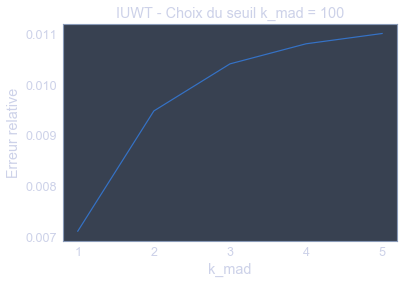

In [34]:
plt.plot(k_mad_list, error_iuwt)
plt.title("IUWT - Choix du seuil k_mad = %d" % mu_list[np.argmin(error_bis)])
plt.xlabel('k_mad')
plt.ylabel('Erreur relative')
plt.show()

# Brouillons et tests

In [142]:
for i in range(len(error_reverse)):
    plt.figure(figsize=(25.0, 17.0))
    plt.suptitle("Proximal Gradient Descent\nEvolution de l'inpainting en fonction du seuil doux\n$\mu$ = %d" % mu_list_reverse[i] + 
                 "\nErreur relative = %.2e" % error_reverse[i], fontsize=20.0)
    plt.subplot(2, 3, 1)
    plt.imshow(x, cmap=cmap)
    plt.title('Input image')
    plt.subplot(2, 3, 3)
    plt.imshow(masked, cmap=cmap)
    plt.title('Masked')
    plt.subplot(2, 3, 4)
    plt.imshow(mask, cmap=cmap)
    plt.title('Mask')
    plt.subplot(2, 3, 2)
    plt.imshow(inpainted_list_reverse[i], cmap=cmap)
    plt.title('Inpainted image')
    plt.subplot(2, 3, 5)
    plt.imshow(x - inpainted_list_reverse[i], cmap=cmap)
    plt.title('Residuals')
#     plt.show()
    display.display(plt.gcf())
    display.clear_output(wait=True)
    sleep(1)

<Figure size 460.8x403.2 with 0 Axes>

KeyboardInterrupt: 

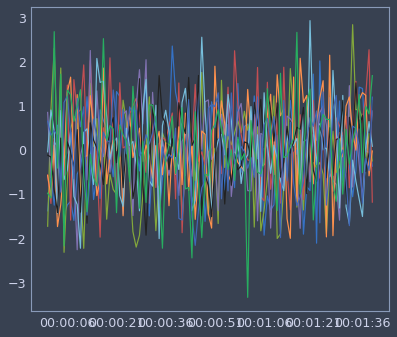

In [39]:
i = pd.date_range('2013-1-1',periods=100,freq='s')

while True:
    try:
        plt.plot(pd.Series(data=np.random.randn(100), index=i))
        display.display(plt.gcf())
        display.clear_output(wait=True)
        sleep(1)
    except KeyboardInterrupt:
        break